## Problem Statement 

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others 


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling 

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [152]:
import json 
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
import os
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint

import warnings
warnings.filterwarnings('ignore')

## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [153]:
# check the files present in /kaggle/input
[file for file in os.walk("/kaggle/input")]

[('/kaggle/input', ['tickets-classification'], []),
 ('/kaggle/input/tickets-classification',
  [],
  ['complaints-2021-05-14_08_16.json'])]

In [154]:
help(os.read)

Help on built-in function read in module posix:

read(fd, length, /)
    Read from a file descriptor.  Returns a bytes object.



In [155]:
# Opening JSON file 
file_path = "/kaggle/input/tickets-classification/complaints-2021-05-14_08_16.json"
with open(file_path,'r') as file:
    data = json.load(file)
df=pd.json_normalize(data)

## Data preparation

In [156]:
# Inspect the dataframe to understand the given data.
print(df.info())

print(df.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   _index                             78313 non-null  object 
 1   _type                              78313 non-null  object 
 2   _id                                78313 non-null  object 
 3   _score                             78313 non-null  float64
 4   _source.tags                       10900 non-null  object 
 5   _source.zip_code                   71556 non-null  object 
 6   _source.complaint_id               78313 non-null  object 
 7   _source.issue                      78313 non-null  object 
 8   _source.date_received              78313 non-null  object 
 9   _source.state                      76322 non-null  object 
 10  _source.consumer_disputed          78313 non-null  object 
 11  _source.product                    78313 non-null  obj

In [157]:
#print the column names
columns = df.columns
print(columns)

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')


Removing the underscore as prefix for all the column names

In [158]:
#Assign new column names
df.columns =  [col.replace("_source.","") if col.startswith("_source")  else col.lstrip("_") for col in columns]
print(df.columns)

Index(['index', 'type', 'id', 'score', 'tags', 'zip_code', 'complaint_id',
       'issue', 'date_received', 'state', 'consumer_disputed', 'product',
       'company_response', 'company', 'submitted_via', 'date_sent_to_company',
       'company_public_response', 'sub_product', 'timely',
       'complaint_what_happened', 'sub_issue', 'consumer_consent_provided'],
      dtype='object')


In [159]:
#Assign nan in place of blanks in the complaints column
print(df[df["complaint_what_happened"] == ""].shape)
df.loc[df["complaint_what_happened"] == "","complaint_what_happened"] = pd.NA

(57241, 22)


In [160]:
df["complaint_what_happened"].isna().sum()

57241

In [161]:
#Remove all rows where complaints column is nan
df = df[~df["complaint_what_happened"].isna()]

In [162]:
df = df.reset_index(drop=True)
df.index

RangeIndex(start=0, stop=21072, step=1)

## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers
* The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis¶


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].


In [163]:
# For parallel processing of apply method in pandas
!pip install swifter

In [164]:
import swifter
import string
import re
from nltk.tokenize import word_tokenize
from nltk import ngrams

punc = string.punctuation
print(punc)

spacy_model = spacy.load("en_core_web_sm")
stopwords = nltk.corpus.stopwords.words('english')

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [165]:
# function to clean the text and remove all the unnecessary elements.
def clean_sent(sent):
    
    sent = sent.lower()
       
    pattern_digits = r'\w*\d+\w*'
    pattern_text_in_brackets = r'\[\w*\]'
    pattern_x = r'\b[x]+\b'
    
    sent = re.sub(pattern_digits,"",sent) 
    sent = re.sub(pattern_text_in_brackets,"",sent)
    sent = re.sub(pattern_x, "",sent)
    sent = "".join([char for char in sent if char not in punc])
    
    sent = " ".join( word for word in sent.split() if word not in stopwords)
    
    return sent


In [166]:
# function which output Lemma form texts and words with only "NN" tag
def lemma_pos_tag_sent(sent):
    tokens = spacy_model(sent)
    sent = " ".join([(word.lemma_).lower() for word in tokens])
    sent_with_nn = " ".join([word.lemma_ for word in tokens if (word.tag_ == "NN")])
    return sent, sent_with_nn


In [167]:
print("Actual complaint: " + "\n" +df["complaint_what_happened"][2])

print("-"*100)

clean_text = clean_sent(df["complaint_what_happened"][2])
print("Clean complaint: " + "\n" + clean_text)

print("-"*100)
sent,sent_with_nn = lemma_pos_tag_sent(clean_text)
print("Lemma complaint: " + "\n" +sent)

print("-"*100)
print("Lemma complaint with only NN tags: " + "\n" +sent_with_nn)

Actual complaint: 
Chase Card was reported on XX/XX/2019. However, fraudulent application have been submitted my identity without my consent to fraudulently obtain services. Do not extend credit without verifying the identity of the applicant.
----------------------------------------------------------------------------------------------------
Clean complaint: 
chase card reported however fraudulent application submitted identity without consent fraudulently obtain services extend credit without verifying identity applicant
----------------------------------------------------------------------------------------------------
Lemma complaint: 
chase card report however fraudulent application submit identity without consent fraudulently obtain service extend credit without verify identity applicant
----------------------------------------------------------------------------------------------------
Lemma complaint with only NN tags: 
card application identity consent credit identity applican

In [168]:
# combine both clean_sent and lemma_pos_tag_sent
def preprocess_sent(sent):
    sent = clean_sent(sent)
    sent, sent_with_nn_tag = lemma_pos_tag_sent(sent)
    return sent, sent_with_nn_tag

In [169]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints 
df_clean = pd.DataFrame()

df_clean['complaints'] = df['complaint_what_happened'].swifter.apply(lambda x : clean_sent(x))
df_clean['output_lemma_tag'] = df['complaint_what_happened'].swifter.apply(lambda x : preprocess_sent(x) )



Pandas Apply:   0%|          | 0/21072 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/21072 [00:00<?, ?it/s]

In [170]:
df_clean[["lemma_complaints","complaint_POS_removed"]] = pd.DataFrame(df_clean['output_lemma_tag'].to_list(),index = df_clean.index)

In [171]:
df_clean = df_clean.drop(['output_lemma_tag'],axis = 1)

In [172]:
df_clean

,complaints,lemma_complaints,complaint_POS_removed
0,good morning name appreciate could help put stop chase bank cardmember services wrote chase asking debt verification sent statement acceptable asking bank validate debt instead receiving mail every month attempting collect debt right know information consumer chase account thanks advance help,good morning name appreciate could help put stop chase bank cardmember service write chase ask debt verification send statement acceptable ask bank validate debt instead receive mail every month attempt collect debt right know information consumer chase account thank advance help,morning name appreciate bank chase debt verification statement bank validate debt mail month collect debt information consumer chase account advance help
1,upgraded card told agent upgrade anniversary date would change turned agent giving wrong information order upgrade account changed anniversary date without consent recording agent misled,upgrade card tell agent upgrade anniversary date would change turn agent give wrong information order upgrade account change anniversary date without consent recording agent mislead,card agent upgrade anniversary date agent information order upgrade account anniversary date consent recording agent
2,chase card reported however fraudulent application submitted identity without consent fraudulently obtain services extend credit without verifying identity applicant,chase card report however fraudulent application submit identity without consent fraudulently obtain service extend credit without verify identity applicant,card application identity consent credit identity applicant
3,trying book ticket came across offer applied towards ticket applied rewards card put information offer within less minute notified via screen decision could made immediately contacted referred chase bank immediately contacted chase bank within getting notification screen told chase representative spoke application denied could state asked infor...,try book ticket come across offer apply towards ticket apply reward card put information offer within less minute notify via screen decision could make immediately contact refer chase bank immediately contact chase bank within get notification screen tell chase representative speak application deny could state ask information offer explain even...,book ticket offer ticket card information offer minute screen decision chase bank chase bank notification screen application state information offer credit offer account statement purchase ticket account application representative application request proceed application chase fact credit account name credit report chase information credit repor...
4,grand son give check deposit chase account fund clear chase bank closed account never paid money said need speek grand son check clear money taking chase bank refuse pay money grand son called chase times told call verify check owner country time date happen check number claim number chase,grand son give check deposit chase account fund clear chase bank closed account never pay money say need speek grand son check clear money take chase bank refuse pay money grand son call chase times tell call verify check owner country time date happen check number claim number chase,son check deposit chase account fund account money son money chase bank money son call verify check owner country check number claim number chase
...,...,...,...
21067,chase card customer well decade offered multiple solicitations acquiring new credit cards chase bonus airline miles hotel points approved new cards annual fee year less months payment always paid agreed chase closed cards one approved new cards never activated sent chase done harm credit charged annual fee even though cancelled account failed c...,chase card customer well decade offer multiple solicitation acquire new credit card chase bonus airline miles hotel point approve new card annual fee year less month payment always pay agree chase 

## Exploratory data analysis to get familiar with the data.


*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




Highest complaint character length: 20028


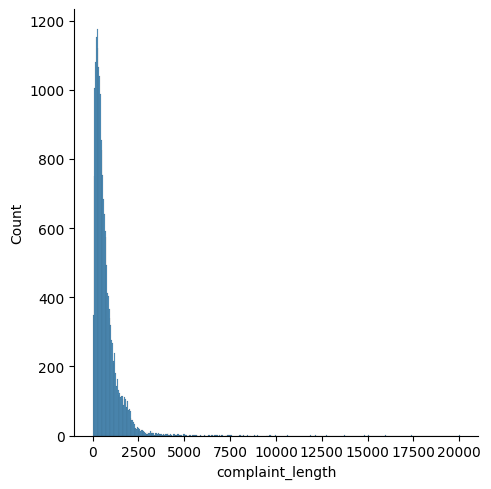

In [173]:
# Write your code here to visualise the data according to the 'Complaint' character length
df_clean["complaint_length"] = df_clean["complaints"].apply(lambda x : (len(x) - x.count(" ")))
print("Highest complaint character length: {}".format(df_clean["complaint_length"].max()))
sns.displot(df_clean['complaint_length'])
plt.show()

Most of the complaint length is within 2500 character(ignoring space)

#### Find the top 40 words by frequency among all the articles after processing the text.

In [174]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text
from wordcloud import WordCloud,STOPWORDS
stopwords = set(STOPWORDS)
all_complaints = ""

all_complaints = " ".join([sentence for sentence in df_clean['complaint_POS_removed']])

In [175]:
all_complaints[0:2000]

'morning name appreciate bank chase debt verification statement bank validate debt mail month collect debt information consumer chase account advance help card agent upgrade anniversary date agent information order upgrade account anniversary date consent recording agent card application identity consent credit identity applicant book ticket offer ticket card information offer minute screen decision chase bank chase bank notification screen application state information offer credit offer account statement purchase ticket account application representative application request proceed application chase fact credit account name credit report chase information credit report process application consent error son check deposit chase account fund account money son money chase bank money son call verify check owner country check number claim number chase inquiry account debit card branch customer service representative account branch deposit place employment bank customer service representati

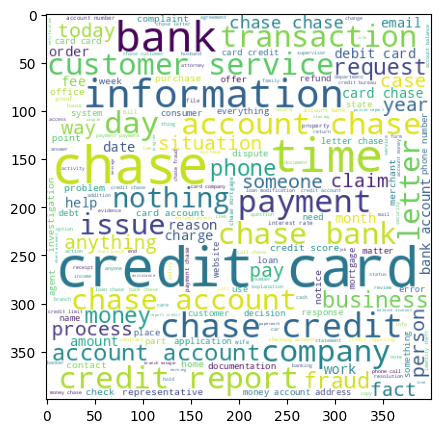

In [176]:
# word cloud to visulize most common words
word_cloud = WordCloud(width=400,height= 400, background_color='white',stopwords=stopwords).generate_from_text(all_complaints)
plt.figure(figsize=(10,5))
plt.imshow(word_cloud)
plt.show()

#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [177]:
# top 40 unigram frequency
word_freq = nltk.FreqDist(all_complaints.split())
word_freq.most_common(40)

[('chase', 58251),
 ('account', 38639),
 ('credit', 32442),
 ('card', 26567),
 ('bank', 18674),
 ('payment', 13960),
 ('time', 11931),
 ('money', 11893),
 ('loan', 9811),
 ('information', 9585),
 ('letter', 8334),
 ('check', 7894),
 ('number', 7752),
 ('mortgage', 7738),
 ('amount', 7533),
 ('phone', 7454),
 ('balance', 7086),
 ('report', 6740),
 ('call', 6601),
 ('fraud', 6537),
 ('customer', 6411),
 ('company', 6321),
 ('charge', 6000),
 ('day', 5638),
 ('dispute', 5392),
 ('business', 5335),
 ('service', 5301),
 ('interest', 5191),
 ('email', 5066),
 ('claim', 4997),
 ('transaction', 4766),
 ('branch', 4646),
 ('fee', 4311),
 ('date', 4271),
 ('name', 4223),
 ('issue', 4218),
 ('home', 4197),
 ('month', 4174),
 ('pay', 3966),
 ('complaint', 3919)]

In [178]:
# the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean). 
tokens = word_tokenize(all_complaints)
ngram_words = 2

bigram_list = list(ngrams(tokens,ngram_words))
word_freq = nltk.FreqDist(bigram_list)
word_freq.most_common(30)

[(('credit', 'card'), 11029),
 (('chase', 'credit'), 3837),
 (('credit', 'report'), 3283),
 (('account', 'chase'), 3206),
 (('chase', 'bank'), 2970),
 (('customer', 'service'), 2951),
 (('chase', 'account'), 2846),
 (('account', 'account'), 2669),
 (('chase', 'chase'), 2063),
 (('card', 'chase'), 2037),
 (('bank', 'account'), 1990),
 (('debit', 'card'), 1868),
 (('chase', 'card'), 1838),
 (('credit', 'score'), 1612),
 (('card', 'account'), 1532),
 (('money', 'account'), 1465),
 (('account', 'credit'), 1403),
 (('letter', 'chase'), 1389),
 (('card', 'credit'), 1177),
 (('phone', 'number'), 1142),
 (('card', 'card'), 1140),
 (('credit', 'credit'), 1112),
 (('account', 'bank'), 1108),
 (('payment', 'chase'), 1090),
 (('interest', 'rate'), 1073),
 (('chase', 'mortgage'), 1054),
 (('account', 'number'), 1048),
 (('checking', 'account'), 1045),
 (('credit', 'reporting'), 1025),
 (('payment', 'payment'), 996)]

In [179]:
# ngram = 3
tokens = word_tokenize(all_complaints)
ngram_words = 3

trigram_list = list(ngrams(tokens,ngram_words))
word_freq = nltk.FreqDist(trigram_list)
word_freq.most_common(40)

[(('chase', 'credit', 'card'), 2247),
 (('credit', 'card', 'chase'), 904),
 (('credit', 'card', 'account'), 858),
 (('credit', 'card', 'company'), 814),
 (('credit', 'card', 'credit'), 606),
 (('chase', 'customer', 'service'), 444),
 (('card', 'credit', 'card'), 437),
 (('credit', 'report', 'credit'), 384),
 (('account', 'credit', 'card'), 335),
 (('chase', 'checking', 'account'), 317),
 (('credit', 'report', 'chase'), 311),
 (('account', 'chase', 'account'), 308),
 (('inquiry', 'credit', 'report'), 298),
 (('bank', 'credit', 'card'), 293),
 (('chase', 'auto', 'finance'), 290),
 (('chase', 'account', 'chase'), 289),
 (('chase', 'bank', 'account'), 253),
 (('account', 'credit', 'report'), 242),
 (('credit', 'card', 'bank'), 240),
 (('credit', 'card', 'card'), 240),
 (('account', 'account', 'account'), 239),
 (('customer', 'service', 'representative'), 236),
 (('freedom', 'credit', 'card'), 227),
 (('credit', 'card', 'balance'), 222),
 (('chase', 'account', 'account'), 220),
 (('victim',

## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [180]:
# code to initialise the TfidfVectorizer 
tf_vectorizer = TfidfVectorizer(max_df=0.95,min_df = 2,stop_words='english')


#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [181]:
#code to create the Document Term Matrix by transforming the complaints column present in df_clean.
tf_matrix = tf_vectorizer.fit_transform(df_clean['complaint_POS_removed'])

In [182]:
pd.DataFrame(tf_matrix.toarray(),columns = tf_vectorizer.get_feature_names_out())

,aarp,abandonment,abate,abatement,abbreviation,abhorrent,abide,ability,abreast,absence,...,yield,yoga,youth,youxxxx,yr,yrs,zilch,zip,zombie,zone
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21067,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
21068,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
21069,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
21070,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.172789,0.0,0.0,0.0,0.0


## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

Steps involved:

* Find the best number of clusters 
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints 
* Correct the labels if needed 
* Map the clusters to topics/cluster names

In [183]:
from sklearn.decomposition import NMF

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [184]:
#Load your nmf_model with the n_components i.e 5
num_topics = 5

#keep the random_state =40
nmf_model = NMF(num_topics,random_state=40)

In [185]:
W = nmf_model.fit_transform(tf_matrix)
H = nmf_model.components_
len(tf_vectorizer.get_feature_names_out())

6168

In [186]:
W

array([[0.00287864, 0.01600331, 0.01919064, 0.02826655, 0.009593  ],
       [0.01126424, 0.0003426 , 0.00132998, 0.00820624, 0.00279014],
       [0.01868052, 0.03488639, 0.        , 0.        , 0.        ],
       ...,
       [0.01219836, 0.0103485 , 0.00643821, 0.02191509, 0.00018144],
       [0.04077158, 0.01478208, 0.00026085, 0.        , 0.11340081],
       [0.        , 0.06081368, 0.        , 0.01461958, 0.13421247]])

In [187]:
H

array([[0.00920526, 0.        , 0.        , ..., 0.00806446, 0.        ,
        0.00134465],
       [0.00013861, 0.        , 0.        , ..., 0.00250023, 0.00183168,
        0.        ],
       [0.        , 0.0015743 , 0.00051742, ..., 0.00351094, 0.00082174,
        0.00363648],
       [0.        , 0.        , 0.        , ..., 0.00037112, 0.        ,
        0.00166438],
       [0.        , 0.        , 0.        , ..., 0.00721605, 0.        ,
        0.00022698]])

In [188]:
#Print the Top15 words for each of the topics
words = np.array(tf_vectorizer.get_feature_names_out())
topic_model_df = pd.DataFrame(np.zeros((num_topics,15)),index = [f'topic{i + 1}' for i in range(num_topics)], columns= [f'word{i+1}' for i in range(15)])
print(topic_model_df)

for i in range(num_topics):
    ix =  H[i].argsort()[::-1][:15]
    topic_model_df.iloc[i] = words[ix]

topic_model_df
                                                                                

        word1  word2  word3  word4  word5  word6  word7  word8  word9  word10  \
topic1    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0     0.0   
topic2    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0     0.0   
topic3    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0     0.0   
topic4    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0     0.0   
topic5    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0     0.0   

        word11  word12  word13  word14  word15  
topic1     0.0     0.0     0.0     0.0     0.0  
topic2     0.0     0.0     0.0     0.0     0.0  
topic3     0.0     0.0     0.0     0.0     0.0  
topic4     0.0     0.0     0.0     0.0     0.0  
topic5     0.0     0.0     0.0     0.0     0.0  


,word1,word2,word3,word4,word5,word6,word7,word8,word9,word10,word11,word12,word13,word14,word15
topic1,card,chase,credit,charge,dispute,fraud,merchant,company,purchase,fee,time,letter,phone,service,customer
topic2,credit,report,inquiry,score,debt,reporting,account,information,identity,limit,company,theft,bureaus,history,card
topic3,loan,mortgage,chase,modification,home,property,foreclosure,letter,rate,time,sale,process,information,house,refinance
topic4,account,bank,money,check,chase,deposit,branch,number,business,fraud,transaction,claim,information,day,customer
topic5,payment,balance,month,statement,fee,date,chase,pay,auto,time,day,car,error,account,history


In [189]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4
topic_int = {
    'topic1' : 0,
    'topic2' : 1,
    'topic3' : 2,
    'topic4' : 3,
    'topic5' : 4,
}


In [190]:
W = pd.DataFrame(W, columns = [f'topic{i+1}' for i in range(num_topics)])
W['topic_int'] = W.apply(lambda x : topic_int.get(x.idxmax()),axis=1)

In [191]:
W

,topic1,topic2,topic3,topic4,topic5,topic_int
0,0.002879,0.016003,0.019191,0.028267,0.009593,3
1,0.011264,0.000343,0.001330,0.008206,0.002790,0
2,0.018681,0.034886,0.000000,0.000000,0.000000,1
3,0.020490,0.053152,0.016107,0.021612,0.000000,1
4,0.000213,0.000000,0.001098,0.070066,0.000000,3
...,...,...,...,...,...,...
21067,0.046044,0.071896,0.000343,0.008198,0.036916,1
21068,0.022377,0.008335,0.006370,0.010984,0.000000,0
21069,0.012198,0.010349,0.006438,0.021915,0.000181,3
21070,0.040772,0.014782,0.000261,0.000000,0.113401,4


In [192]:
#Assign the best topic to each of the cmplaints in Topic Column

df_clean['Topic'] = W["topic_int"]

In [193]:
df_clean.head()

,complaints,lemma_complaints,complaint_POS_removed,complaint_length,Topic
0,good morning name appreciate could help put stop chase bank cardmember services wrote chase asking debt verification sent statement acceptable asking bank validate debt instead receiving mail every month attempting collect debt right know information consumer chase account thanks advance help,good morning name appreciate could help put stop chase bank cardmember service write chase ask debt verification send statement acceptable ask bank validate debt instead receive mail every month attempt collect debt right know information consumer chase account thank advance help,morning name appreciate bank chase debt verification statement bank validate debt mail month collect debt information consumer chase account advance help,253,3
1,upgraded card told agent upgrade anniversary date would change turned agent giving wrong information order upgrade account changed anniversary date without consent recording agent misled,upgrade card tell agent upgrade anniversary date would change turn agent give wrong information order upgrade account change anniversary date without consent recording agent mislead,card agent upgrade anniversary date agent information order upgrade account anniversary date consent recording agent,162,0
2,chase card reported however fraudulent application submitted identity without consent fraudulently obtain services extend credit without verifying identity applicant,chase card report however fraudulent application submit identity without consent fraudulently obtain service extend credit without verify identity applicant,card application identity consent credit identity applicant,147,1
3,trying book ticket came across offer applied towards ticket applied rewards card put information offer within less minute notified via screen decision could made immediately contacted referred chase bank immediately contacted chase bank within getting notification screen told chase representative spoke application denied could state asked infor...,try book ticket come across offer apply towards ticket apply reward card put information offer within less minute notify via screen decision could make immediately contact refer chase bank immediately contact chase bank within get notification screen tell chase representative speak application deny could state ask information offer explain even...,book ticket offer ticket card information offer minute screen decision chase bank chase bank notification screen application state information offer credit offer account statement purchase ticket account application representative application request proceed application chase fact credit account name credit report chase information credit repor...,762,1
4,grand son give check deposit chase account fund clear chase bank closed account never paid money said need speek grand son check clear money taking chase bank refuse pay money grand son called chase times told call verify check owner country time date happen check number claim number chase,grand son give check deposit chase account fund clear chase bank closed account never pay money say need speek grand son check clear money take chase bank refuse pay money grand son call chase times tell call verify check owner country time date happen check number claim number chase,son check deposit chase account fund account money son money chase bank money son call verify check owner country check number claim number chase,242,3


In [194]:
df_clean.shape

(21072, 5)

In [195]:
pd.set_option('display.max_colwidth', 350)

In [196]:
#Print the first 5 Complaint for each of the Topics
df_clean_1=df_clean.groupby('Topic').tail(5)
df_clean_1.sort_values('Topic')

,complaints,lemma_complaints,complaint_POS_removed,complaint_length,Topic
21068,wednesday called chas visa credit card provider asked make claim purchase protection benefit purchased three high school textbooks year old daughter transferred new school three books damaged water bottle backpack broke chase representative assured textbooks would covered instructed file claim immediately went website filed claim including uplo...,wednesday call chas visa credit card provider ask make claim purchase protection benefit purchase three high school textbook year old daughter transfer new school three book damage water bottle backpack break chase representative assure textbook would cover instruct file claim immediately go website file claim include upload request paperwork i...,visa credit card provider claim purchase protection benefit school year daughter school water bottle backpack representative file claim website claim paperwork copy credit card statement evidence damage website type item cover claim claim insurance provider review information contact business outline process email claim submission claim informa...,1134,0
21064,filed dispute credit card company chase visa online purchase made chase visa kept closing dispute even though wasnt resolved acting upon misinformation vendor called discuss provide necessary documentation advised reopen another dispute four times since written disputes werent getting reviewed attempted phone resolution many times many chase as...,file dispute credit card company chase visa online purchase make chase visa keep closing dispute even though be not resolve act upon misinformation vendor call discuss provide necessary documentation advise reopen another dispute four time since write dispute be not getting review attempt phone resolution many time many chase associate foreign ...,dispute credit card company chase visa purchase chase visa closing dispute misinformation vendor documentation dispute phone resolution chase service chase branch assistance branch manager matter discover time chase visa research dispute followup fault chase responsibility failure resolve matter,583,0
21063,applied chase card using online portal chase clearly read terms conditions price terms apply card clearly mentioned like intro apr first months account open based creditworthiness aprs vary market based prime rate applied approved card apr didnt provide promotional apr mentioned online contacted chase customer care immediately computer mistake ...,apply chase card use online portal chase clearly read term condition price term apply card clearly mention like intro apr first month account open base creditworthiness aprs vary market base prime rate apply approve card apr do not provide promotional apr mention online contact chase customer care immediately computer mistake get apr please wai...,chase card chase price card aprs market rate card apr chase customer care computer mistake chase branch issue document website screenshot application change anything price card friend customer,590,0
21062,tried buy concert tickets someone know assume risk tried careful could asked lot questions asked ticket confirmation ultimately scammed dollars using chase quickpay ive tried remediate issue companies unwilling anything chase unwilling conduct sort investigation contact users bank account try remediate issue unwilling anything research done mad...,try buy concert ticket someone know assume risk try careful could ask lot question ask ticket confirmation ultimately scamme dollar use chase quickpay i ve try remediate issue company unwilling anything chase unwilling conduct sort investigation contact user bank account try remediate issue unwilling anything research done make transaction seem...,concert someone risk lot ticket confirmation chase quickpay issue anything conduct sort investigation contact issue anything research transaction company anything fix continue bank chase anything selfservice product use chase selfservice debit

In [197]:
df_clean['Topic'].unique()

array([3, 0, 1, 4, 2])

In [198]:
topic_names_int = {  
    0 : "Theft/Dispute Reporting",
    1 : "Credit card or prepaid card",
    2 : "Mortgage/Loan",
    3 : "Bank Account services",
    4 : "Others"}
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(topic_names_int)

#### Topic identified:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [199]:
#Create the dictionary again of Topic names and Topics

topic_names = {  
    "Theft/Dispute Reporting" : 0,
    "Credit card or prepaid card" : 1,
    "Mortgage/Loan" : 2,
    "Bank Account services" : 3,
    "Others" : 4}
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(topic_names)

## Supervised model to predict any new complaints to the relevant Topics.


In [200]:
df_clean

,complaints,lemma_complaints,complaint_POS_removed,complaint_length,Topic
0,good morning name appreciate could help put stop chase bank cardmember services wrote chase asking debt verification sent statement acceptable asking bank validate debt instead receiving mail every month attempting collect debt right know information consumer chase account thanks advance help,good morning name appreciate could help put stop chase bank cardmember service write chase ask debt verification send statement acceptable ask bank validate debt instead receive mail every month attempt collect debt right know information consumer chase account thank advance help,morning name appreciate bank chase debt verification statement bank validate debt mail month collect debt information consumer chase account advance help,253,3
1,upgraded card told agent upgrade anniversary date would change turned agent giving wrong information order upgrade account changed anniversary date without consent recording agent misled,upgrade card tell agent upgrade anniversary date would change turn agent give wrong information order upgrade account change anniversary date without consent recording agent mislead,card agent upgrade anniversary date agent information order upgrade account anniversary date consent recording agent,162,0
2,chase card reported however fraudulent application submitted identity without consent fraudulently obtain services extend credit without verifying identity applicant,chase card report however fraudulent application submit identity without consent fraudulently obtain service extend credit without verify identity applicant,card application identity consent credit identity applicant,147,1
3,trying book ticket came across offer applied towards ticket applied rewards card put information offer within less minute notified via screen decision could made immediately contacted referred chase bank immediately contacted chase bank within getting notification screen told chase representative spoke application denied could state asked infor...,try book ticket come across offer apply towards ticket apply reward card put information offer within less minute notify via screen decision could make immediately contact refer chase bank immediately contact chase bank within get notification screen tell chase representative speak application deny could state ask information offer explain even...,book ticket offer ticket card information offer minute screen decision chase bank chase bank notification screen application state information offer credit offer account statement purchase ticket account application representative application request proceed application chase fact credit account name credit report chase information credit repor...,762,1
4,grand son give check deposit chase account fund clear chase bank closed account never paid money said need speek grand son check clear money taking chase bank refuse pay money grand son called chase times told call verify check owner country time date happen check number claim number chase,grand son give check deposit chase account fund clear chase bank closed account never pay money say need speek grand son check clear money take chase bank refuse pay money grand son call chase times tell call verify check owner country time date happen check number claim number chase,son check deposit chase account fund account money son money chase bank money son call verify check owner country check number claim number chase,242,3
...,...,...,...,...,...
21067,chase card customer well decade offered multiple solicitations acquiring new credit cards chase bonus airline miles hotel points approved new cards annual fee year less months payment always paid agreed chase closed cards one approved new cards never activated sent chase done harm credit charged annual fee even though cancelled account failed c...,chase card customer well decade offer multiple solicitation acquire new credit card chase bonus airline miles hotel point approve new ca

In [201]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data=df_clean[['complaints','Topic']]

In [202]:
training_data

,complaints,Topic
0,good morning name appreciate could help put stop chase bank cardmember services wrote chase asking debt verification sent statement acceptable asking bank validate debt instead receiving mail every month attempting collect debt right know information consumer chase account thanks advance help,3
1,upgraded card told agent upgrade anniversary date would change turned agent giving wrong information order upgrade account changed anniversary date without consent recording agent misled,0
2,chase card reported however fraudulent application submitted identity without consent fraudulently obtain services extend credit without verifying identity applicant,1
3,trying book ticket came across offer applied towards ticket applied rewards card put information offer within less minute notified via screen decision could made immediately contacted referred chase bank immediately contacted chase bank within getting notification screen told chase representative spoke application denied could state asked infor...,1
4,grand son give check deposit chase account fund clear chase bank closed account never paid money said need speek grand son check clear money taking chase bank refuse pay money grand son called chase times told call verify check owner country time date happen check number claim number chase,3
...,...,...
21067,chase card customer well decade offered multiple solicitations acquiring new credit cards chase bonus airline miles hotel points approved new cards annual fee year less months payment always paid agreed chase closed cards one approved new cards never activated sent chase done harm credit charged annual fee even though cancelled account failed c...,1
21068,wednesday called chas visa credit card provider asked make claim purchase protection benefit purchased three high school textbooks year old daughter transferred new school three books damaged water bottle backpack broke chase representative assured textbooks would covered instructed file claim immediately went website filed claim including uplo...,0
21069,familiar pay understand great risk provides consumers believed safe chase bank app chase almost years trust mobile banking sadly regretful told deal merchant except merchant refused answer inquiries shut communication website said merchant looks entirely legitamite even using faces highly successful brands individuals linked social media withou...,3
21070,flawless credit yrs ive chase credit cards chase freedom specifically since problems ever ive done many balance transfers life plenty experience recently balance transfer chase freedom many chase cards apparently freeedom got first bill minimum payment shocked immediately called representative told min payment high bc making pay balance transfe...,4


#### Apply the supervised models on the training data created.
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [203]:
X = training_data['complaints']
y = training_data['Topic']

In [204]:
#Write your code to get the Vector count
count_vectoriser = CountVectorizer()
X_matrix = count_vectoriser.fit_transform(X)


#Write your code here to transform the word vector to tf-idf
from sklearn.feature_extraction.text import TfidfTransformer
tf_tranformer = TfidfTransformer()
tf_matrix = tf_tranformer.fit_transform(X_matrix)


In [205]:
tf_matrix.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [206]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(tf_matrix,y,test_size=0.2,random_state=42)

Lets try following models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes

**Using the required evaluation metrics lets judge the tried models and select the ones performing the best**

In [207]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB


from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support

In [236]:
# custom metrics evalutation report
def metrics_report(model):
    metrics = []
    
    y_train_pred = model.predict(X_train)
    y_train_pred_prob = model.predict_proba(X_train)
    
    y_test_pred = model.predict(X_test)
    y_test_pred_prob = model.predict_proba(X_test)    
   
    
    precision_train,recall_train,fscore_train,support_train = precision_recall_fscore_support(y_train,y_train_pred,average='weighted')
    precision_test,recall_test,fscore_test,support_test = precision_recall_fscore_support(y_test,y_test_pred,average='weighted')
    
    train_accuracy = accuracy_score(y_train,y_train_pred)
    test_accuracy = accuracy_score(y_test,y_test_pred)
    print("train accuracy score: {}".format(train_accuracy))
    print("test accuracy score: {}".format(test_accuracy))
    
    
    print("classification report on train data: {}".format(classification_report(y_train,y_train_pred),labels=[0,1,2,3,4]))
    print("classification report on test data: {}".format(classification_report(y_test,y_test_pred),labels=[0,1,2,3,4]))
    
    roc_curve_score = roc_auc_score(y_test,y_test_pred_prob,average='weighted',multi_class='ovr')
    print("roc_curve_score: {}".format(roc_curve_score))
    
    cm = confusion_matrix(y_test,y_test_pred,labels=[0,1,2,3,4])
    sns.heatmap(cm,annot=True,cmap='Greens',fmt='d')
    plt.show()
    
    metrics += [train_accuracy,test_accuracy,roc_curve_score,
                   precision_train,precision_test,
                   recall_train,recall_test,
                   fscore_train,fscore_test]
    return metrics

# **Logistic regression**

In [215]:
lgr = LogisticRegression()
lgr_model = lgr.fit(X_train,y_train)

train accuracy score: 0.9710506021237468
test accuracy score: 0.9212336892052194
classification report on train data:               precision    recall  f1-score   support

           0       0.96      0.98      0.97      3941
           1       0.98      0.95      0.97      2861
           2       0.98      0.98      0.98      3076
           3       0.96      0.99      0.98      5213
           4       0.98      0.93      0.96      1766

    accuracy                           0.97     16857
   macro avg       0.97      0.96      0.97     16857
weighted avg       0.97      0.97      0.97     16857

classification report on test data:               precision    recall  f1-score   support

           0       0.90      0.93      0.91       995
           1       0.94      0.90      0.92       736
           2       0.94      0.93      0.93       722
           3       0.91      0.95      0.93      1315
           4       0.95      0.84      0.89       447

    accuracy                   

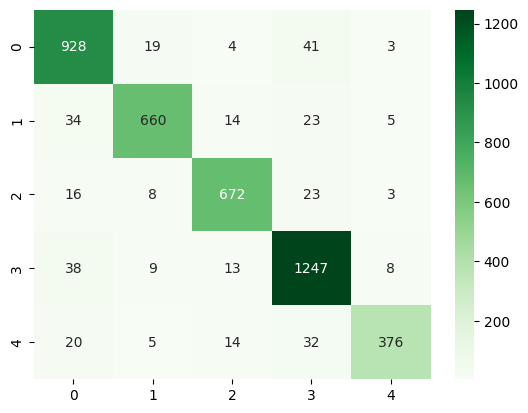

In [237]:
metrics_lgr = metrics_report(lgr_model)

# **Decision Tree Algorithm**

In [217]:
# common method to aply gridsearch cross validation
def gridsearchcv_model(model,params,cv,scoring):
    grid_model = GridSearchCV(model,params,cv=cv,n_jobs=-1,scoring=scoring,verbose=1)
    grid_mode = grid_model.fit(X_train,y_train)
    return grid_model
    

In [218]:
# instatiate decision tree and provide params for gridsearch cv
dt = DecisionTreeClassifier(random_state=42)
folds=5
params = {
    'criterion' : ['gini','entropy'],
    'max_depth' : [5,10,20,50],
    'min_samples_split' : [10,20,50],
    'min_samples_leaf' : [10,20,50]
}

dt_grid_model = gridsearchcv_model(dt,params,folds,'roc_auc_ovr')

Fitting 5 folds for each of 72 candidates, totalling 360 fits


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [219]:
# select the best performing model
print(dt_grid_model.best_score_)
dt_grid_model.best_estimator_

0.9572043299828268


DecisionTreeClassifier(criterion='entropy', max_depth=20, min_samples_leaf=50,
                       min_samples_split=10, random_state=42)

train accuracy score: 0.8409562792905024
test accuracy score: 0.8196915776986952
classification report on train data:               precision    recall  f1-score   support

           0       0.84      0.84      0.84      3941
           1       0.81      0.81      0.81      2861
           2       0.83      0.85      0.84      3076
           3       0.87      0.87      0.87      5213
           4       0.83      0.80      0.81      1766

    accuracy                           0.84     16857
   macro avg       0.84      0.83      0.83     16857
weighted avg       0.84      0.84      0.84     16857

classification report on test data:               precision    recall  f1-score   support

           0       0.80      0.81      0.80       995
           1       0.80      0.80      0.80       736
           2       0.82      0.82      0.82       722
           3       0.85      0.86      0.85      1315
           4       0.80      0.77      0.78       447

    accuracy                   

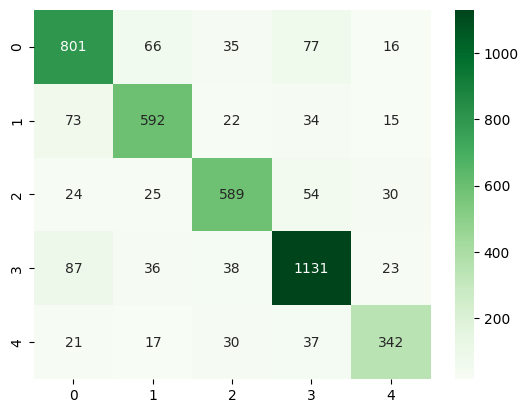

In [240]:
dt = DecisionTreeClassifier(criterion='entropy', max_depth=20, min_samples_leaf=50,
                       min_samples_split=10, random_state=42)
dt = dt.fit(X_train,y_train)

metrics_dt = metrics_report(dt)

# **Random Forest Algorithm**

In [221]:
# instatiate random forest and provide params for gridsearch cv
rf_model = RandomForestClassifier(random_state=42,n_jobs=-1,oob_score=True)
folds = 5
params = {
    'n_estimators' : [50,100,200],
    'criterion' : ['gini','entropy'],
    'max_depth' : [5,10,20,50],
    'min_samples_split' : [10,20,50],
    'min_samples_leaf' : [10,20,50]
}

rf_grid_model = gridsearchcv_model(rf_model,params,folds,'roc_auc_ovr')

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


In [222]:
rf_grid_model.best_estimator_

RandomForestClassifier(max_depth=50, min_samples_leaf=10, min_samples_split=50,
                       n_estimators=200, n_jobs=-1, oob_score=True,
                       random_state=42)

In [223]:
# select the best estimation and fit the training data
rf_model = rf_grid_model.best_estimator_

rf_model.fit(X_train,y_train)

RandomForestClassifier(max_depth=50, min_samples_leaf=10, min_samples_split=50,
                       n_estimators=200, n_jobs=-1, oob_score=True,
                       random_state=42)

train accuracy score: 0.8163967491249926
test accuracy score: 0.7710557532621589
classification report on train data:               precision    recall  f1-score   support

           0       0.82      0.85      0.83      3941
           1       0.85      0.77      0.81      2861
           2       0.88      0.86      0.87      3076
           3       0.76      0.96      0.85      5213
           4       0.98      0.33      0.50      1766

    accuracy                           0.82     16857
   macro avg       0.86      0.75      0.77     16857
weighted avg       0.83      0.82      0.80     16857

classification report on test data:               precision    recall  f1-score   support

           0       0.76      0.78      0.77       995
           1       0.81      0.72      0.76       736
           2       0.86      0.83      0.84       722
           3       0.72      0.94      0.81      1315
           4       0.95      0.24      0.38       447

    accuracy                   

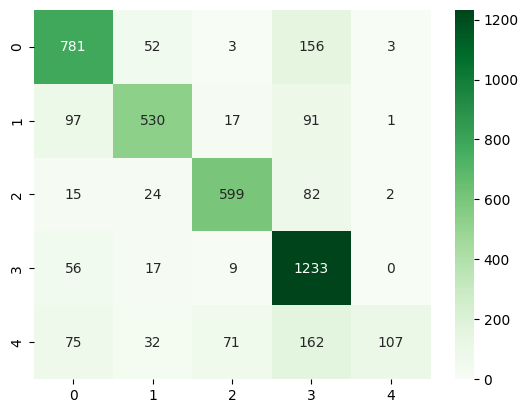

In [241]:
metrics_rf = metrics_report(rf_model)

# **Naive Bayes Algorithm**

Fitting 5 folds for each of 5 candidates, totalling 25 fits


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Fitting 5 folds for each of 5 candidates, totalling 25 fits
train accuracy score: 0.8462953075873524
test accuracy score: 0.7527876631079478
classification report on train data:               precision    recall  f1-score   support

           0       0.85      0.85      0.85      3941
           1       0.84      0.81      0.83      2861
           2       0.89      0.89      0.89      3076
           3       0.82      0.92      0.87      5213
           4       0.86      0.59      0.70      1766

    accuracy                           0.85     16857
   macro avg       0.85      0.81      0.83     16857
weighted avg       0.85      0.85      0.84     16857

classification report on test data:               precision    recall  f1-score   support

           0       0.74      0.73      0.73       995
           1       0.74      0.71      0.72       736
           2       0.82      0.84      0.83       722
           3       0.73      0.86      0.79      1315
           4       0.75   

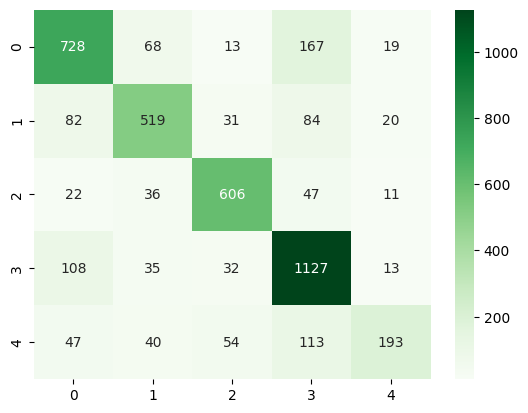

In [242]:
# using multinomial naive bayes version
navie_bayes = MultinomialNB()
folds = 5
params = {
    'alpha' : [0.001,0.01,0.02,0.05,0.1]
}
nb_grid_model = gridsearchcv_model(navie_bayes,params,folds,'roc_auc_ovr')
nb_grid_model.fit(X_train,y_train)

metrics_nb = metrics_report(nb_grid_model)

# **Analysis on results**

In [250]:
results = pd.DataFrame(index = ['logistic regression','decision tree','random forest','naive bayes'],
                      columns = ['train_accuracy','test_accuracy','roc_curve_score',
                   'precision_train','precision_test',
                   'recall_train','recall_test',
                   'fscore_train','fscore_test'])
results.loc['logistic regression'] = metrics_lgr
results.loc['decision tree'] = metrics_dt
results.loc['random forest'] = metrics_rf
results.loc['naive bayes'] = metrics_nb
results

,train_accuracy,test_accuracy,roc_curve_score,precision_train,precision_test,recall_train,recall_test,fscore_train,fscore_test
logistic regression,0.971051,0.921234,0.994251,0.971261,0.922148,0.971051,0.921234,0.970975,0.921038
decision tree,0.840956,0.819692,0.959549,0.840885,0.819556,0.840956,0.819692,0.840882,0.819553
random forest,0.816397,0.771056,0.964326,0.833201,0.791669,0.816397,0.771056,0.804072,0.753788
naive bayes,0.846295,0.752788,0.937211,0.847794,0.753551,0.846295,0.752788,0.843408,0.746908


**Logistic regression performance better compared to the other model. So lets test with some custom texts to check its performance**

# **Custom message tests**

In [251]:
custom_text = ["I applied for bank account one month ago. But I see my account is not yet activated. Can someone help me with this?",
               "I applied for credit card one month ago. Two weeks I got confirmation for that the credit card application is approved and the card will be dispatched and card will be dispatched soon. But I havnt received the card yet.", 
               "I have a loan with chase bank with reference number XXXXX which I would like to pay off all the amount and close the mortage. Can you explain the process?"]

In [252]:
# clean the texts
custom_text = [clean_sent(sent) for sent in custom_text]

In [253]:
# Transform the custom texts with existing count_vectoriser and tf_transformer
custom_vec = count_vectoriser.transform(custom_text)
custom_tf = tf_tranformer.transform(custom_vec)

In [254]:
# Fit and predit using logistic regression model
custom_predition = lgr_model.predict(custom_tf)
print(custom_predition)

[3 0 2]


In [255]:
# View result as dataframe as an overview.
custom_df = pd.DataFrame({'custom sentences' : custom_text,
                          'final model output' : custom_predition,
                         'topic mapping': [topic_names_int[i] for i in custom_predition]})
custom_df

,custom sentences,final model output,topic mapping
0,applied bank account one month ago see account yet activated someone help,3,Bank Account services
1,applied credit card one month ago two weeks got confirmation credit card application approved card will dispatched card will dispatched soon havnt received card yet,0,Theft/Dispute Reporting
2,loan chase bank reference number pay amount close mortage explain process,2,Mortgage/Loan


**Model predicts correct on the custom texts as well.**